In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame,Series 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp

### データの分析

In [39]:
df = pd.read_csv('train.csv')
df.head(10)
#sulfur dioxide : 二酸化硫黄 residual sugar :残糖 chlorides :塩化化合物 
#fixed acidity : 揮発しない酸 volatile acidity:揮発する酸 critic acid : クエン酸
#sulfate : 硫酸塩 density: 密度

#大部分の酸は不揮発性で、クエン酸は少量しか含まれないのが普通らしい。
#（fixed acid以外切り取る説が浮上してきた）
#甘味と酸味のバランスが大事というのは再三言われている。
#sulfur dioxide は酸化防止剤らしい。加えると雑菌が減って美味しくなる？
#だいたい６００mg以上のvolatile acidity(CH3COOH)は不純物として認識されてしまうらしい。

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 12 columns):
fixed acidity           1119 non-null float64
volatile acidity        1119 non-null float64
citric acid             1119 non-null float64
residual sugar          1119 non-null float64
chlorides               1119 non-null float64
free sulfur dioxide     1119 non-null float64
total sulfur dioxide    1119 non-null float64
density                 1119 non-null float64
pH                      1119 non-null float64
sulphates               1119 non-null float64
alcohol                 1119 non-null float64
quality                 1119 non-null int64
dtypes: float64(11), int64(1)
memory usage: 105.0 KB


In [41]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000
mean,8.678105,0.521649,0.295979,2.579267,0.089721,15.207328,47.179625,0.997167,3.296461,0.665532,10.334227,5.650581
std,1.795471,0.178961,0.198815,1.277500,0.048806,10.085498,34.210922,0.001853,0.156366,0.178248,1.074463,0.810473
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.400000,0.390000,0.120000,1.900000,0.072000,7.000000,22.000000,0.996200,3.190000,0.560000,9.500000,5.000000
50%,8.300000,0.510000,0.290000,2.250000,0.081000,13.000000,38.000000,0.997200,3.300000,0.620000,10.000000,6.000000
75%,9.700000,0.630000,0.470000,2.700000,0.092500,21.000000,63.000000,0.998200,3.390000,0.730000,11.000000,6.000000
max,15.900000,1.330000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003200,3.900000,2.000000,14.900000,8.000000


In [42]:
#各クオリティーの数を把握
df.groupby("quality")["quality"].count()

quality
3      5
4     32
5    493
6    420
7    157
8     12
Name: quality, dtype: int64

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


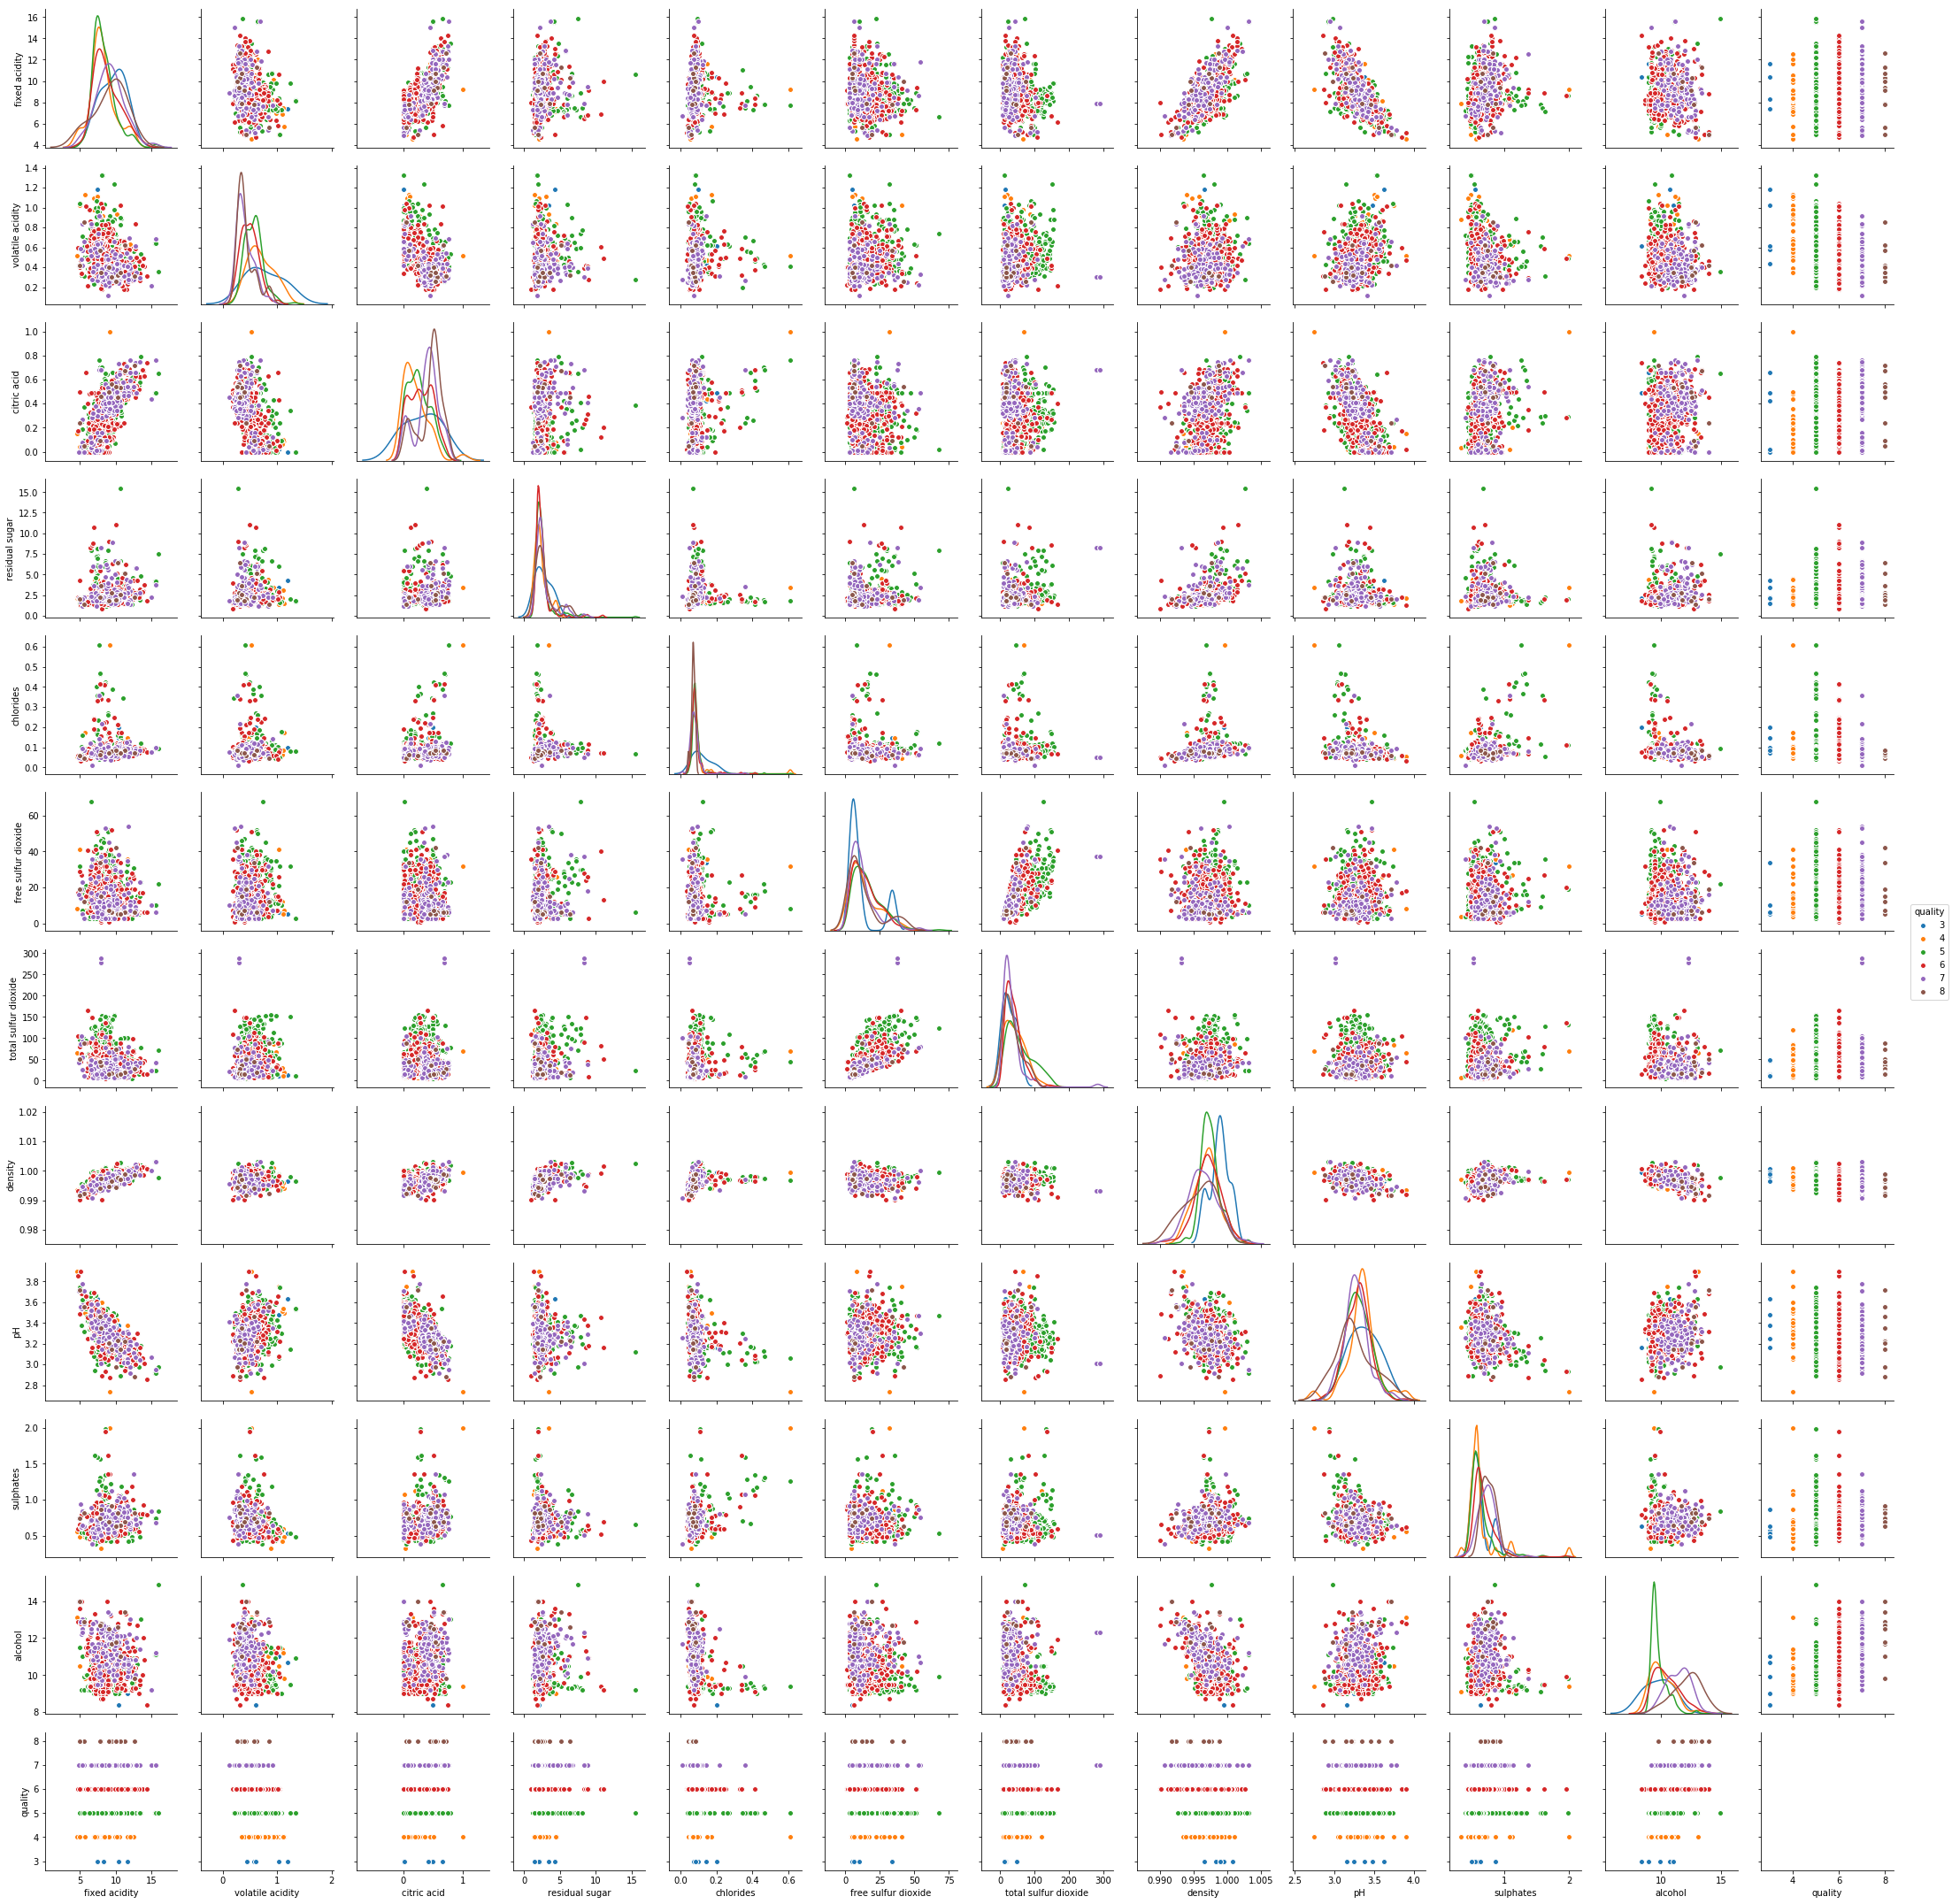

In [21]:
#データ同士の相関をざっくり見るために散布図を作成
g = sns.pairplot(df,hue = "quality",diag_kind="kde")
plt.show()

### 試みた事

#### 内容面からのアプローチ
ワインは味のバランスが大事と聞いたので、fixed acidityとresidual sugarの比を求めてqualityとの相関を見てみた。　＞＞　相関はほぼないようだった。
また、結合しているsulfur dioxideとqualityの相関も調べた。　＞＞　相関はほぼ無いようだった
qualityは味覚で感じるので、感覚の強さは刺激に対して対数の関係にあるから、対数をとって計算した。　＞＞　少しスコアが良くなった。

ほとんど相関がないと思われたdensityとcitric acidの行を落として機械学習させた。

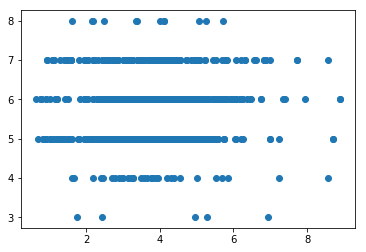

In [22]:
data= DataFrame(df["fixed acidity"] / df["residual sugar"])
data.rename(columns = {0:"acid sugar balance"}, inplace = True)
plt.scatter(x=data["acid sugar balance"],y = df["quality"])

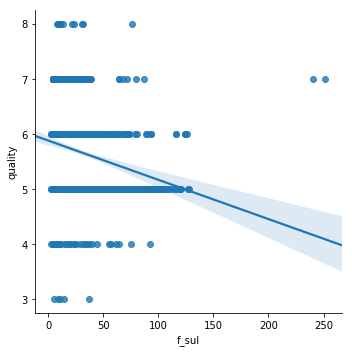

In [23]:
data2 = DataFrame(df["total sulfur dioxide"] - df["free sulfur dioxide"])
data3 = pd.concat ([df,data2],axis =1)
#columnの名前が0になっちゃってるんで、変えた。
data3.rename ( columns = {0:"f_sul"},inplace = True)

sns.lmplot(x = "f_sul",y = "quality",data = data3,size = 5)

In [ ]:
df1 = df.copy()

In [24]:
#各行の数値を対数化する。

for i in range(0,len(df1["fixed acidity"])):
    df1["fixed acidity"][i] = math.log(df1["fixed acidity"][i])

for i in range(0,len(df1['volatile acidity'])):
    df1['volatile acidity'][i] = math.log(df1['volatile acidity'][i])
    
for i in range(0,len(df1['residual sugar'])):
    df1['residual sugar'][i] = math.log(df1['residual sugar'][i])

for i in range(0,len(df1['chlorides'])):
    df1['chlorides'][i] = math.log(df1['chlorides'][i])

for i in range(0,len(df1['free sulfur dioxide'])):
    df1['free sulfur dioxide'][i] = math.log(df1['free sulfur dioxide'][i])

for i in range(0,len(df1['total sulfur dioxide'])):
    df1['total sulfur dioxide'][i] = math.log(df1['total sulfur dioxide'][i])

for i in range(0,len(df1['sulphates'])):
    df1['sulphates'][i] = math.log(df1['sulphates'][i])

for i in range(0,len(df1['alcohol'])):
    df1['alcohol'][i] = math.log(df1['alcohol'][i])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.

In [36]:
df1 = df1.drop(["density","citric acid"],axis =1)

### 前処理（正規化、分割など）

In [50]:
#外れ値処理用の関数を作成した


def drop_outlier(df):
    df1 = df.copy()
    for i, col in df1.iteritems():
        
    #四分位数
        q1 = col.describe()['25%']
        q3 = col.describe()['75%']
        iqr = q3 - q1 #四分位範囲

    #外れ値の基準点
        outlier_min = q1 - (iqr) * 1.25
        outlier_max = q3 + (iqr) * 1.25

    #範囲から外れている値を除く
        col[col < outlier_min] = None
        col[col > outlier_max] = None
    return df1  

#元のデータフレームが書き変わらないようにする関数

def drop_outlier_conduct(df):
    
    df1 = drop_outlier(df)
    df2 = df1.dropna(how ='any', axis = 0 , inplace = False)
    
    return df2

In [51]:
# データをトレーニング用/テスト用に分割
train_df, test_df = train_test_split(df1, test_size = 0.2)
# indexをリセットする
#train_df = train_df[train_df["quality"] != 3]
#train_df = train_df[train_df["quality"] != 8]　　<<これらは使わずとも、drop_outlierによって削除されてしまう。
train_df = drop_outlier_conduct(train_df)


train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality
0,1.887070,-0.349557,0.470004,-2.577022,1.791759,2.708050,3.44,-0.544727,2.370244,5.0
1,2.186051,-1.171183,0.693147,-2.198225,3.258097,4.442651,3.26,-0.634878,2.272126,5.0
2,1.960095,-0.385662,0.788457,-2.617296,2.484907,3.091042,3.48,-0.693147,2.230014,5.0
3,1.856298,-0.462035,0.470004,-2.525729,2.484907,3.465736,3.58,-0.415515,2.282382,5.0
4,2.219203,-0.843970,0.832909,-2.488915,2.639057,3.135494,3.35,-0.494296,2.424803,6.0


In [52]:
#どれくらい外れ値で削られたかの目安
print(len(train_df))
train_df.groupby("quality")["quality"].count()

686


quality
4.0     16
5.0    319
6.0    268
7.0     83
Name: quality, dtype: int64

In [53]:
# 各カラムごとに正規化する
for column_name in train_df.columns:    
    # Classカラムは正規化しない
    if column_name == 'quality':
        continue
        
    # 指定されたカラムを抽出
    train_column = train_df[column_name]
    test_column = test_df[column_name]
    
    # trainを用いて平均と分散を計算する
    scaler = preprocessing.StandardScaler().fit(train_column.values.reshape(-1, 1))
    #  正規化
    train_df.loc[:, column_name] = scaler.transform(train_column.values.reshape(-1, 1))
    test_df.loc[:, column_name] = scaler.transform(test_column.values.reshape(-1, 1))

    
#numpyのarrayに直している
X_train =train_df.drop('quality', axis=1).values
y_train =train_df['quality'].values


X_test = test_df.drop('quality', axis=1).values
y_test = test_df['quality'].values



### ロジスティック回帰
仕組みはわかりやすいようだがスコアが出ない。

In [56]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, logistic.predict(X_test)))

             precision    recall  f1-score   support

          4       0.00      0.00      0.00         7
          5       0.65      0.81      0.72       102
          6       0.48      0.44      0.46        80
          7       0.50      0.36      0.42        33
          8       0.00      0.00      0.00         2

avg / total       0.54      0.58      0.56       224



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SVM

In [58]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
#GridSearchCVでパラメータチューニング
#C gannma エラーの許容度
svc = svm.SVC()
param_grid = [
    {'C': [15000,10000,5000], 'kernel': ['rbf'], 'gamma': [0.00075,0.00025,0.0005]},
    ]

#評価関数はmse
clf = GridSearchCV(svc, param_grid,cv=5,n_jobs = -1, scoring = "mean_squared_error")
clf.fit(X_train, y_train)
#評価を見やすく整理
result = pd.DataFrame(clf.cv_results_)
result_scored = result.sort_values(by=["rank_test_score"])[["params","mean_test_score","std_test_score","mean_fit_time"]]
print(clf.best_estimator_)
result_scored.head(10)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/m

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/m

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/m

SVC(C=5000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.00025, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

,params,mean_test_score,std_test_score,mean_fit_time
7,"{'C': 5000, 'gamma': 0.00025, 'kernel': 'rbf'}",-0.400875,0.048235,0.084509
4,"{'C': 10000, 'gamma': 0.00025, 'kernel': 'rbf'}",-0.405248,0.049058,0.105526
1,"{'C': 15000, 'gamma': 0.00025, 'kernel': 'rbf'}",-0.412536,0.049782,0.118703
8,"{'C': 5000, 'gamma': 0.0005, 'kernel': 'rbf'}",-0.412536,0.043722,0.106553
5,"{'C': 10000, 'gamma': 0.0005, 'kernel': 'rbf'}",-0.428571,0.051522,0.151660
2,"{'C': 15000, 'gamma': 0.0005, 'kernel': 'rbf'}",-0.431487,0.032293,0.178950
3,"{'C': 10000, 'gamma': 0.00075, 'kernel': 'rbf'}",-0.438776,0.047465,0.184177
6,"{'C': 5000, 'gamma': 0.00075, 'kernel': 'rbf'}",-0.438776,0.049328,0.132747
0,"{'C': 15000, 'gamma': 0.00075, 'kernel': 'rbf'}",-0.447522,0.046609,0.252955


### XG Boost
仕組みは全然理解していないが一番よく精度が出た。

In [54]:
import xgboost as xgb

#RandomizedSearchCVでパラメータチューニング
param_distributions={'max_depth': sp.stats.randint(1,11),
                     'subsample': sp.stats.uniform(0.5,0.5),
                     'colsample_bytree': sp.stats.uniform(0.5,0.5)
}

xgb_model = xgb.XGBClassifier()
rs = RandomizedSearchCV(xgb_model,
                        param_distributions,
                        cv=10,
                        n_iter=20,
                        scoring="mean_squared_error",
                        n_jobs=1,
                        verbose=2)
rs.fit(X_train,y_train)

predict = rs.predict(X_test)
#スコアが見やすいよう整理
result = pd.DataFrame(rs.cv_results_)
result_scored = result.sort_values(by=["rank_test_score"])[["params","mean_test_score","std_test_score","mean_fit_time"]]


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 
[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 
[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 
[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 
[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 
[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 
[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789 
[CV]  colsample_bytree=0.6559916711841333, max_depth=2, subsample=0.6442786121139789, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 
[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 
[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 
[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 
[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864 
[CV]  colsample_bytree=0.7313240488421344, max_depth=3, subsample=0.8482148711691864, total=   0.1s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.2s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.2s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.2s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.2s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.2s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.2s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.2s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.3s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.2s
[CV] colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6199802317072953, max_depth=10, subsample=0.7251813020833706, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6997025619668706, max_depth=7, subsample=0.935427941644039, total=   0.2s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.2s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.3s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.2s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.2s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.3s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.3s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.3s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.3s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.3s
[CV] colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.790445922188872, max_depth=7, subsample=0.8637570481987058, total=   0.3s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 
[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 
[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 
[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 
[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 
[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8190955112380861, max_depth=3, subsample=0.8443744051233453, total=   0.1s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5650205071785261, max_depth=9, subsample=0.9083408674333773, total=   0.2s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 
[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.1s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.2s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 
[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.1s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.2s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 
[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.1s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.2s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 
[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.2s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.2s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 
[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.1s
[CV] colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6859871616543873, max_depth=4, subsample=0.7482006001929274, total=   0.2s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 
[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.2s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.2s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 
[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.2s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.2s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 
[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.1s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.1s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 
[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.2s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.2s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 
[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.2s
[CV] colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.577509892995983, max_depth=5, subsample=0.7563773652160772, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_

[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 
[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 
[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_

[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 
[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_

[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_

[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_

[CV]  colsample_bytree=0.5268566690105314, max_depth=7, subsample=0.8560286579842016, total=   0.2s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 
[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 
[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 
[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_

[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 
[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 
[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 
[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 
[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144 
[CV]  colsample_bytree=0.5234248490325155, max_depth=1, subsample=0.699276421991144, total=   0.0s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 
[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 
[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 
[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 
[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762 
[CV]  colsample_bytree=0.5419010342950558, max_depth=5, subsample=0.8467688788744762, total=   0.1s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.2s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 
[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.1s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.1s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 
[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.1s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.2s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 
[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.2s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.2s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 
[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.1s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.2s
[CV] colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529 
[CV]  colsample_bytree=0.6763743109568092, max_depth=4, subsample=0.7283007372445529, total=   0.1s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.2s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.3s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.3s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.3s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.3s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.3s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.3s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.3s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.3s
[CV] colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9033621383995514, max_depth=8, subsample=0.5843991459223536, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9942841248742549, max_depth=7, subsample=0.6172316237676607, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 
[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_

[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 
[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_

[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 
[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693 
[CV]  colsample_bytree=0.5016097400860953, max_depth=8, subsample=0.7243297238634693, total=   0.2s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_

[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 
[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 
[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 
[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 
[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 
[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5800569709941794, max_depth=3, subsample=0.9076696393991148, total=   0.1s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 
[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.2s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.2s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 
[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.1s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.2s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 
[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.2s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.2s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 
[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.1s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.2s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 
[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.2s
[CV] colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.5239009965466171, max_depth=6, subsample=0.6610427464682345, total=   0.2s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.3s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.3s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.2s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.3s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.2s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.3s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.3s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.2s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.3s
[CV] colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.9064166805144551, max_depth=7, subsample=0.8206132497602812, total=   0.3s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.3s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.3s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.2s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.2s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.2s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.2s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.2s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.2s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.2s
[CV] colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263 


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is 

[CV]  colsample_bytree=0.8746618612006691, max_depth=9, subsample=0.5454787364443263, total=   0.2s


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a

In [55]:
print(rs.best_estimator_)
print(predict)
result_scored.head(10)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9064166805144551, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8206132497602812)
[5. 6. 5. 6. 5. 5. 5. 5. 5. 6. 6. 6. 5. 7. 6. 5. 5. 5. 5. 5. 5. 6. 4. 6.
 7. 5. 5. 5. 5. 5. 5. 6. 6. 6. 5. 5. 5. 6. 6. 5. 5. 7. 6. 5. 5. 5. 6. 6.
 5. 5. 6. 6. 5. 5. 6. 6. 6. 7. 7. 4. 5. 6. 5. 6. 6. 5. 6. 5. 5. 6. 5. 7.
 6. 6. 7. 6. 5. 6. 6. 6. 5. 6. 7. 6. 5. 5. 6. 7. 5. 5. 5. 5. 7. 5. 5. 5.
 5. 5. 5. 4. 6. 5. 6. 6. 5. 6. 6. 5. 5. 6. 5. 5. 5. 5. 5. 6. 5. 6. 5. 6.
 6. 5. 6. 6. 5. 6. 5. 6. 5. 5. 5. 6. 7. 5. 5. 5. 6. 5. 6. 7. 5. 6. 5. 5.
 6. 5. 5. 5. 6. 5. 7. 6. 6. 5. 6. 7. 5. 6. 5. 5. 6. 6. 6. 5. 6. 5. 6. 6.
 6. 6. 6. 5. 7. 6. 5. 6. 7. 5. 5. 5. 5. 5. 5. 5. 6. 6. 5. 6. 

,params,mean_test_score,std_test_score,mean_fit_time
18,"{'colsample_bytree': 0.9064166805144551, 'max_...",-0.333819,0.077048,0.257141
19,"{'colsample_bytree': 0.8746618612006691, 'max_...",-0.344023,0.069310,0.241380
7,"{'colsample_bytree': 0.6859871616543873, 'max_...",-0.344023,0.049223,0.149560
14,"{'colsample_bytree': 0.9942841248742549, 'max_...",-0.346939,0.065060,0.234554
5,"{'colsample_bytree': 0.8190955112380861, 'max_...",-0.349854,0.055058,0.112531
6,"{'colsample_bytree': 0.5650205071785261, 'max_...",-0.349854,0.060288,0.234138
4,"{'colsample_bytree': 0.790445922188872, 'max_d...",-0.351312,0.062130,0.255780
8,"{'colsample_bytree': 0.577509892995983, 'max_d...",-0.351312,0.058562,0.151693
1,"{'colsample_bytree': 0.7313240488421344, 'max_...",-0.361516,0.068985,0.110415
13,"{'colsample_bytree': 0.9033621383995514, 'max_...",-0.362974,0.073582,0.257365


### テストデータの整形

In [61]:
df_submission = pd.read_csv("test.csv")
df3 = df_submission.copy()
df3.head()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0,5.6,0.66,0.00,2.5,0.066,7.0,15.0,0.99256,3.52,0.58,12.9
1,1,7.9,0.54,0.34,2.5,0.076,8.0,17.0,0.99235,3.20,0.72,13.1
2,2,6.6,0.50,0.00,1.8,0.062,21.0,28.0,0.99352,3.44,0.55,12.3
3,3,6.3,0.47,0.00,1.4,0.055,27.0,33.0,0.99220,3.45,0.48,12.3
4,4,10.7,0.40,0.37,1.9,0.081,17.0,29.0,0.99674,3.12,0.65,11.2


In [62]:
df3.describe()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,239.500000,7.483958,0.542208,0.212687,2.444479,0.082210,17.431250,44.808333,0.995766,3.345271,0.640938,10.629896
std,138.708327,1.260519,0.178649,0.171681,1.676295,0.042318,11.141876,29.569559,0.001580,0.144147,0.145855,1.016256
min,0.000000,5.000000,0.160000,0.000000,1.200000,0.038000,3.000000,7.000000,0.990800,2.880000,0.370000,8.500000
25%,119.750000,6.700000,0.407500,0.050000,1.800000,0.065000,8.750000,22.000000,0.994915,3.260000,0.540000,9.800000
50%,239.500000,7.200000,0.540000,0.210000,2.100000,0.076000,15.000000,37.000000,0.995775,3.350000,0.620000,10.500000
75%,359.250000,8.000000,0.645000,0.330000,2.300000,0.083000,24.000000,60.000000,0.996617,3.420000,0.720000,11.300000
max,479.000000,12.600000,1.580000,0.780000,15.400000,0.415000,72.000000,160.000000,1.003690,4.010000,1.330000,14.000000


In [63]:
for i in range(0,len(df3["fixed acidity"])):
    df3["fixed acidity"][i] = math.log(df3["fixed acidity"][i])

for i in range(0,len(df3['volatile acidity'])):
    df3['volatile acidity'][i] = math.log(df3['volatile acidity'][i])

for i in range(0,len(df3['residual sugar'])):
    df3['residual sugar'][i] = math.log(df3['residual sugar'][i])

for i in range(0,len(df3['residual sugar'])):
    df3['residual sugar'][i] = math.log(df3['residual sugar'][i])

for i in range(0,len(df3['chlorides'])):
    df3['chlorides'][i] = math.log(df3['chlorides'][i])

for i in range(0,len(df3['free sulfur dioxide'])):
    df3['free sulfur dioxide'][i] = math.log(df3['free sulfur dioxide'][i])

for i in range(0,len(df3['total sulfur dioxide'])):
    df3['total sulfur dioxide'][i] = math.log(df3['total sulfur dioxide'][i])

for i in range(0,len(df3['sulphates'])):
    df3['sulphates'][i] = math.log(df3['sulphates'][i])

for i in range(0,len(df3['alcohol'])):
    df3['alcohol'][i] = math.log(df3['alcohol'][i])

df3.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0,1.722767,-0.415515,0.00,-0.087422,-2.718101,1.945910,2.708050,0.99256,3.52,-0.544727,2.557227
1,1,2.066863,-0.616186,0.34,-0.087422,-2.577022,2.079442,2.833213,0.99235,3.20,-0.328504,2.572612
2,2,1.887070,-0.693147,0.00,-0.531391,-2.780621,3.044522,3.332205,0.99352,3.44,-0.597837,2.509599
3,3,1.840550,-0.755023,0.00,-1.089240,-2.900422,3.295837,3.496508,0.99220,3.45,-0.733969,2.509599
4,4,2.370244,-0.916291,0.37,-0.443395,-2.513306,2.833213,3.367296,0.99674,3.12,-0.430783,2.415914


In [64]:
df3 = df3.drop(["id","citric acid","density"],axis = 1)

In [65]:
# 各カラムごとに正規化する
for column_name in df3.columns:    
           
    # 指定されたカラムを抽出
    submit_column = df3[column_name]
       
    # trainを用いて平均と分散を計算する
    scaler = preprocessing.StandardScaler().fit(submit_column.values.reshape(-1, 1))
    #  正規化
    df3.loc[:, column_name] = scaler.transform(submit_column.values.reshape(-1, 1))
    
df3.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol
0,-1.728178,0.724227,0.570692,-0.482862,-1.037654,-1.287301,1.213428,-0.356876,2.115316
1,0.420153,0.152806,0.570692,-0.040432,-0.840447,-1.103271,-1.008851,0.654349,2.279686
2,-0.702368,-0.066345,-0.595377,-0.678929,0.584840,-0.369594,0.657858,-0.605258,1.606466
3,-0.992811,-0.242538,-2.060545,-1.054631,0.955996,-0.128016,0.727305,-1.241916,1.606466
4,2.314282,-0.701758,-0.364257,0.159384,0.272767,-0.317999,-1.564421,0.176015,0.605546


In [66]:
#numpy.arrayに変換した
df3 = df3.values

In [67]:
print(rs.predict(df3))

[6. 7. 6. 6. 6. 6. 6. 6. 6. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 5. 5. 6. 5. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 6. 6. 5. 7. 7. 6. 5. 6. 6. 7. 5. 5. 6. 6.
 7. 6. 6. 5. 6. 7. 6. 6. 6. 5. 6. 5. 6. 6. 5. 6. 5. 5. 6. 6. 6. 5. 5. 6.
 5. 7. 5. 5. 5. 5. 5. 6. 5. 5. 6. 6. 5. 6. 6. 6. 5. 6. 6. 6. 5. 6. 6. 5.
 6. 5. 6. 6. 6. 7. 7. 5. 6. 6. 5. 5. 6. 7. 5. 7. 5. 5. 6. 5. 5. 6. 5. 5.
 5. 5. 5. 6. 5. 5. 6. 5. 6. 6. 6. 6. 6. 5. 5. 6. 5. 5. 5. 6. 6. 6. 5. 5.
 5. 6. 6. 6. 6. 5. 6. 6. 6. 6. 5. 6. 5. 6. 5. 5. 6. 5. 5. 6. 6. 5. 6. 6.
 6. 5. 5. 6. 6. 6. 5. 6. 5. 5. 6. 7. 5. 6. 6. 6. 6. 5. 5. 5. 6. 5. 5. 5.
 6. 6. 5. 5. 5. 6. 6. 5. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 5. 5. 5. 5. 5. 5.
 6. 6. 6. 6. 6. 6. 6. 5. 6. 5. 6. 5. 5. 5. 5. 5. 6. 5. 5. 6. 5. 5. 5. 5.
 5. 6. 5. 5. 5. 6. 5. 5. 5. 5. 5. 5. 7. 5. 5. 5. 5. 5. 6. 5. 5. 5. 5. 5.
 5. 5. 5. 6. 6. 6. 5. 6. 5. 5. 5. 5. 5. 5. 5. 5. 6. 5. 5. 7. 6. 6. 7. 7.
 6. 7. 6. 6. 6. 7. 5. 6. 6. 6. 7. 5. 5. 5. 6. 6. 5. 6. 6. 6. 6. 6. 7. 6.
 5. 7. 6. 5. 5. 5. 5. 5. 5. 6. 5. 6. 6. 5. 5. 6. 6.

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [68]:
test = np.array(rs.predict(df3))
np.savetxt('out.csv',test,delimiter='.')

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
